# NonLocal Potential from SG15

You can perform calcuatiion in any mode. 


In [1]:
from gpaw import GPAW, FermiDirac
from gpaw.wavefunctions.pw import PW
from ase.io import read
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

c = 20
PW_cut=400
atoms = read('hBN.cif')
atoms.cell[2,2]=c
atoms.center()

calc = GPAW(mode='fd',xc='PBE',h=0.05,
            kpts={'size': (4, 4, 1)},
            setups='sg15',
            occupations=FermiDirac(0.0001),
            txt='scf.txt')

atoms.set_calculator(calc)
atoms.get_potential_energy()
calc.write('gs_sg15.gpw')

## Optimised Vanderbilt norm-conserving pseudopotential


Optimised vanderbilt norm-conserving pseudopotentials are fully nonlocal and have form:
$$ V_{NL}=\left|\chi_i>V_{i}<\chi_i\right|$$
It is possible to extract $|\chi_i>$ from GPAW using following code:

In [3]:
from gpaw.wavefunctions.pw import PWLFC
from gpaw.wavefunctions.pw import PWDescriptor
from ase.units import Hartree

#first of all we need to create PWDescriptor to describe reciprocal grid of our calculation
#ecut - cutoff of our reciprocal grid
#gd - GridDescriptor of our calculation
#kd - KpointDescriptor of our calculation
pd=PWDescriptor(ecut=600/Hartree,gd=calc.wfs.gd,kd=calc.wfs.kd,dtype=complex)

#lets create and collect splines which decribe chi_i in radial form
spline_aj = []
for setup in calc.wfs.setups:
    spline_aj.append(setup.pt_j)
    
#create PWLFC to perform mapping chi_i from radial form to reciprocal space
lfc=PWLFC(spline_aj,pd)
#set position of atoms
lfc.set_positions(calc.spos_ac)

#collect chi_i in real space using FFT
proj_G=[];proj_r=[]
for kpt in calc.wfs.kpt_u:
    proj_G.append(lfc.expand(kpt.q))
    proj=[];n_i=proj_G[-1].shape[1]
    for i in range(n_i):
        proj.append(pd.ifft(proj_G[-1][:,i].copy(),kpt.q))
    proj_r.append(proj)
chi=np.array(proj_r)


nk,nai,nx,ny,nz=chi.shape

### Visualization $|\chi_i|^2$ 

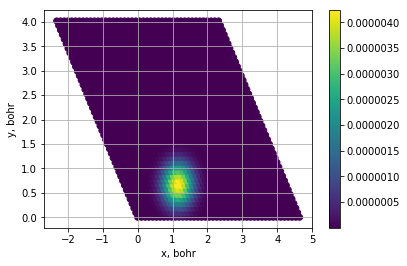

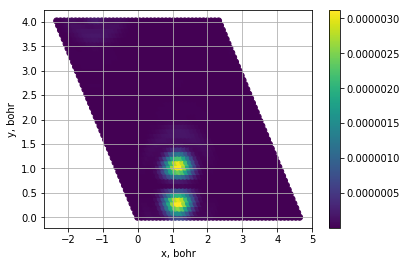

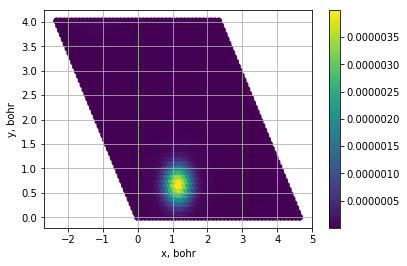

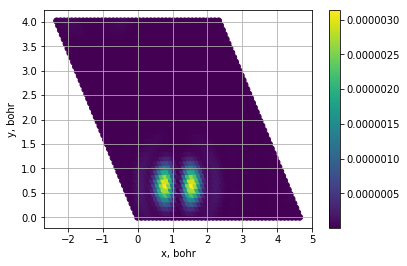

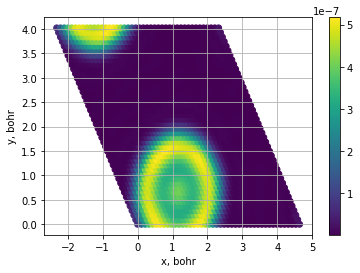

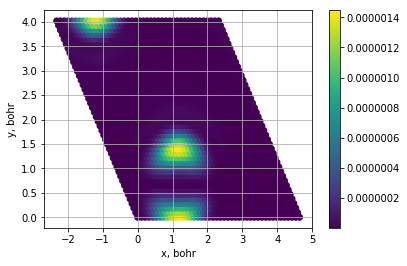

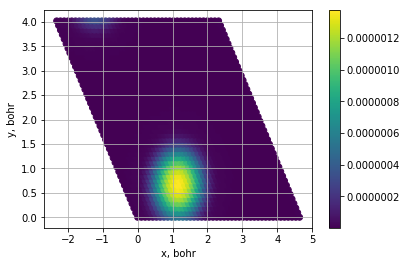

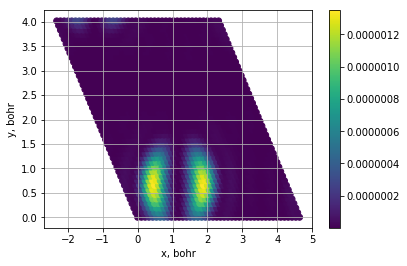

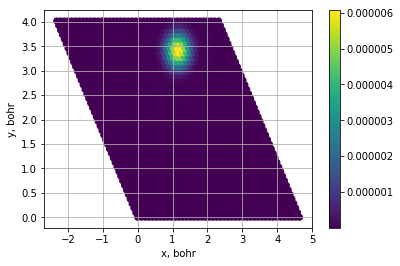

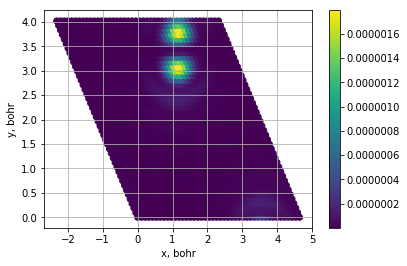

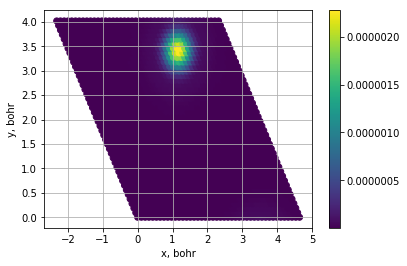

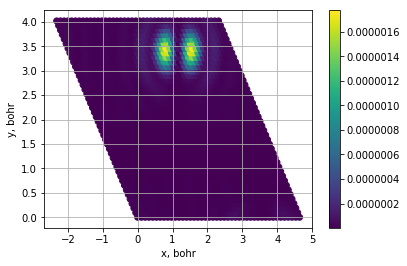

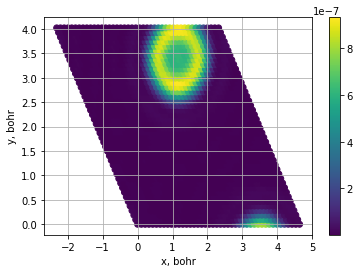

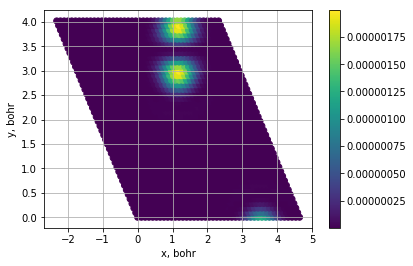

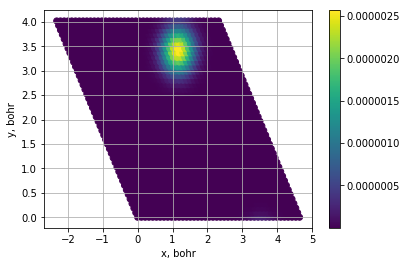

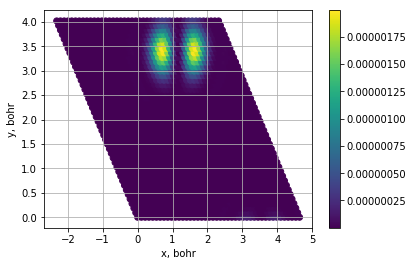

In [4]:
r=calc.wfs.gd.get_grid_point_coordinates()
for i in range(nai):
    plt.figure()
    density=np.abs(chi[0,i])**2
    plt.scatter(r[0,:,:,0],r[1,:,:,0],c=density.sum(axis=2))
    plt.xlabel('x, bohr')
    plt.ylabel('y, bohr')
    plt.grid()
    plt.colorbar()

Also, it is possible to extract from GPAW $V_i$ using following code:

In [5]:
from gpaw.utilities import unpack
# s=0 because we perform spin-paired calculation
s=0
#collect V 
V=[]
for a in range(len(calc.wfs.setups)):
    dH_ii = unpack(calc.hamiltonian.dH_asp[a][s])
    V.append(dH_ii.diagonal())
V=np.array(V);V=V.ravel()

In [6]:
V

array([ 17.3679372 , -11.7113953 , -11.7113953 , -11.7113953 ,
         0.78467865,  -2.9764959 ,  -2.9764959 ,  -2.9764959 ,
        28.28376216, -19.12713381, -19.12713381, -19.12713381,
         3.91243226,  -5.31280494,  -5.31280494,  -5.31280494])